# Automatic Cardiac Diagnosis Challenge (ACDC) Dataset: Global Strain

To develop DeepStrain we used the Automated Cardiac Diagnosis Challenge ([ACDC](https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html)) dataset, consisting of cine-MRI data from 150 subjects evenly divided into five groups: healthy and patients with hypertrophic cardiomyopathy (HCM), abnormal right ventricle (ARV), myocardial infarction with reduced ejection fraction (MI), and dilated cardiomyopathy (DCM). These data were publicly available as train (n = 100) and test (n = 50) sets, with manual segmentations included for the train set only. 

In our [paper](https://www.frontiersin.org/articles/10.3389/fcvm.2021.730316/full) we reported the following parameters for the ACDC dataset: 

In [106]:
from IPython.display import Image
Image(url= "https://www.frontiersin.org/files/Articles/730316/fcvm-08-730316-HTML-r1/image_m/fcvm-08-730316-t002.jpg")

In this notebook we will replicate these results. Computation of strain rate is more complex and will be done separately in a different notebook. Note that there might be some details included here that are missing from the automated (i.e., script) approach. We will incorporate these missing features as we encounter them. In any case, this notebook serves as an excellent starting point to use our method. 

In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import glob
import time
import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass

from tensorflow.keras.optimizers import Adam
from options.test_options import TestOptions
from models import deep_strain_model
from utils import myocardial_strain
from scipy.ndimage import gaussian_filter

## Define Model 

To avoid using the command line scripts, here we create an `options` class to load the network directly. All we have to do is to specify the model path, etc. **For your part, download the ACDC dataset and change the path.**

In [3]:
def normalize(x, axis=(0,1,2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x-mu)/(sd+1e-8)

In [4]:
class Options():
    
    def __init__(self):
        
        self.datadir = '../../../../datasets/ACDC'
        self.isTrain = False
        self.volume_shape = (128,128,16,1)
        self.pretrained_models_netS  = '../pretrained_models/carson_Jan2021.h5'
        self.pretrained_models_netME = '../pretrained_models/carmen_Jan2021.h5'
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

## Global End-Systolic Strain in Healthy Subjects 

The values listed above correspond to the 20 healthy subjects in the ACDC training set (IDs 61-80).

../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")
../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


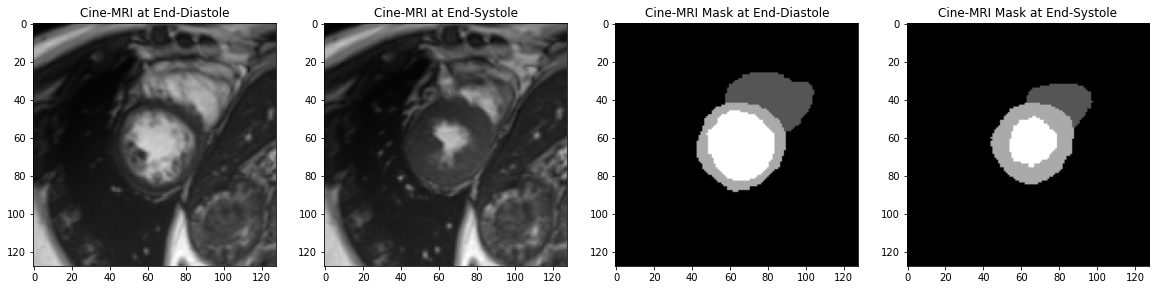

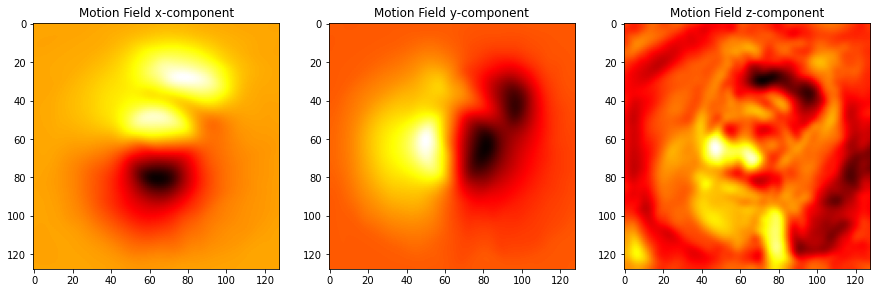

In [ ]:
df = {'SubjectID':[], 'RadialStain':[], 'CircumferentialStrain':[]}

for j, id in enumerate(range(61,81)):
    
    # load end-diastolic (ED) and end-systolic (ES) niftis
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    ES = int(info.ES.item())
    ED = int(info.ED.item())
    
    # let's focus on CarMEN and simply load the ground-truth segmentation
    V_nifti_ED = nib.load(os.path.join(patient_folder, patientid+'_frame%.2d.nii.gz'%(ED)))
    V_nifti_ES = nib.load(os.path.join(patient_folder, patientid+'_frame%.2d.nii.gz'%(ES)))
    M_nifti_ED = nib.load(os.path.join(patient_folder, patientid+'_frame%.2d_gt.nii.gz'%(ED)))
    M_nifti_ES = nib.load(os.path.join(patient_folder, patientid+'_frame%.2d_gt.nii.gz'%(ES)))
    
    # the network expect two frames concatenated along the last dimension
    V_nifti = nib.funcs.concat_images((V_nifti_ED, V_nifti_ES))
    M_nifti = nib.funcs.concat_images((M_nifti_ED, M_nifti_ES))
    
    # data was trained with:
    #  in-plane resolution of 1.25 mm x 1.25 mm
    #  number of slices = 16
    #  variable slice thickness since we specify number of slices
    V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)

    # calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
    center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2)
    V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
    M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)
    
    if j == 0:
        plt.figure(figsize=(20,5))
        plt.subplot(141); plt.imshow(V[:,:,8,0], cmap='gray'); plt.title('Cine-MRI at End-Diastole')
        plt.subplot(142); plt.imshow(V[:,:,8,1], cmap='gray'); plt.title('Cine-MRI at End-Systole')
        plt.subplot(143); plt.imshow(M[:,:,8,0], cmap='gray'); plt.title('Cine-MRI Mask at End-Diastole')
        plt.subplot(144); plt.imshow(M[:,:,8,1], cmap='gray'); plt.title('Cine-MRI Mask at End-Systole')
        plt.show()

    # normalization function used is included in this script for convenience  
    V = normalize(V)

    nx, ny, nz, nt = V.shape

    V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
    V_t =  V[:,:,:,1:]

    V_0 = np.transpose(V_0, (3,0,1,2))
    V_t = np.transpose(V_t, (3,0,1,2))

    # the output is motion estimates of shape (nt, nx, ny, nz, 3)
    y_t = netME([V_0, V_t]).numpy()

    # smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
    # used to deform an endocardial contour. 
    y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))


    if j == 0:
        plt.figure(figsize=(15,5))
        plt.subplot(131); plt.imshow(y_t[0,:,:,8,0], cmap='hot'); plt.title('Motion Field x-component')
        plt.subplot(132); plt.imshow(y_t[0,:,:,8,1], cmap='hot'); plt.title('Motion Field y-component')
        plt.subplot(133); plt.imshow(y_t[0,:,:,8,2], cmap='hot'); plt.title('Motion Field z-component')
        plt.show()
        
    mask_end_diastole = M[..., 0]
    
    strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
    strain.calculate_strain(lv_label=2)

    df['SubjectID']             += [id]
    df['RadialStain']           += [100*strain.Err[strain.mask_rot==2].mean()]   
    df['CircumferentialStrain'] += [100*strain.Ecc[strain.mask_rot==2].mean()]

    
    if j == 0:
        plt.figure(figsize=(10,5))
        plt.subplot(121); plt.imshow(strain.Err[:,:,8], cmap='RdBu'); plt.title('Global Radial Strain')
        plt.subplot(122); plt.imshow(strain.Ecc[:,:,8], cmap='RdBu_r'); plt.title('Global Circumferential Strain')
        plt.show() 

In [ ]:
sns.scatterplot(x='RadialStain', y='CircumferentialStrain', data=pd.DataFrame(df))

In [77]:
pd.DataFrame(df).mean()

SubjectID                70.500000
RadialStain              24.456806
CircumferentialStrain   -17.845301
dtype: float64

In [7]:
pd.DataFrame(df).std()

SubjectID                5.916080
RadialStain              2.993700
CircumferentialStrain    1.632103
dtype: float64

These results are identical to the ones reported in the manuscript. 

## Global Strain in All Subjects 

Now we would like to replicate the plots for strain across all time frames and across all subjects. In this case we don't have the ground-truh segmentations for the entire 4D dataset, therefore we will use carson to generate the masks. 

#### Segmentation 4D

In [4]:
class Options():
    
    def __init__(self):
        
        self.datadir = '../../../../datasets/ACDC'
        self.isTrain = False
        self.image_shape = (128,128,1)
        self.nlabels = 4
        self.pretrained_models_netS  = '../pretrained_models/carson_Jan2021.h5'
        self.pretrained_models_netME = '../pretrained_models/carmen_Jan2021.h5'
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netS  = model.get_netS()

In [5]:
from data import base_dataset
def get_mask(V):
    nx, ny, nz, nt = V.shape
    
    M = np.zeros((nx,ny,nz,nt))
    v = V.transpose((2,3,0,1)).reshape((-1,nx,ny)) # (nz*nt,nx,ny)
    v = normalize(v)
    m = netS(v[:,nx//2-64:nx//2+64,ny//2-64:ny//2+64,None])
    M[nx//2-64:nx//2+64,ny//2-64:ny//2+64] += np.argmax(m, -1).transpose((1,2,0)).reshape((128,128,nz,nt))
    
    return M

subject 1 / 100


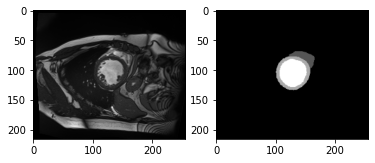

subject 2 / 100
subject 3 / 100
subject 4 / 100
subject 5 / 100
subject 6 / 100
subject 7 / 100
subject 8 / 100
subject 9 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 10 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 11 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 12 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 13 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 14 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 15 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 16 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 17 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 18 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 19 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 20 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 21 / 100
subject 22 / 100
subject 23 / 100
subject 24 / 100
subject 25 / 100
subject 26 / 100
subject 27 / 100
subject 28 / 100
subject 29 / 100
subject 30 / 100
subject 31 / 100
subject 32 / 100
subject 33 / 100
subject 34 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 35 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 36 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 37 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 38 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 39 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 40 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 41 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 42 / 100
subject 43 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 44 / 100
subject 45 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 46 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 47 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 48 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 49 / 100
subject 50 / 100
subject 51 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 52 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 53 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 54 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 55 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 56 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 57 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 58 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 59 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 60 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 61 / 100
subject 62 / 100
subject 63 / 100
subject 64 / 100
subject 65 / 100
subject 66 / 100
subject 67 / 100
subject 68 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 69 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 70 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 71 / 100
subject 72 / 100
subject 73 / 100
subject 74 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 75 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 76 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 77 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 78 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 79 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 80 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 81 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 82 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 83 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 84 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 85 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 86 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 87 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 88 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 89 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 90 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 91 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 92 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 93 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 94 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 95 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 96 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 97 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 98 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 99 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 100 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


total time: 1236.7773838043213


In [14]:
start = time.time()
for j, id in enumerate(range(1, 101)):
    print('subject %d / %d'%(j+1, 100))
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    # notice that in this case the number of slices is set to none, therefore the resolution is kept
    # along the slice dimension.
    V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=None)
    
    # here we normalize per image, not volume
    V = V_nifti_resampled.get_fdata()
    V = normalize(V, axis=(0,1))
    
    # In this case we don't yet have a segmentation we can use to crop the image. 
    # In most cases we can simply center crop (see `get_mask` function): 
    M = get_mask(V)
    
    # However, in some instances the image could end up outside the FOV. While this is unlikely, please inspect 
    # your data.
    
    if False:
        # ONLY IF YOU KNOW YOUR IMAGE IS ROUGHLY NEAR CENTER 
        M_nifti_resampled = nib.Nifti1Image(M, affine=V_nifti_resampled.affine)
        # resample back to original resolution
        M_nifti = base_dataset.resample_nifti_inv(nifti_original=M_nifti_resampled, 
                                                  zooms=M_nifti_resampled.header.get_zooms()[:3], 
                                                  order=0, mode='nearest')
        
    else:
        # We could use VCN to center the heart, but an alternative approach is to use V as an approximate segmentation
        # to center the image. This of course means that we need to do the inverse opereation if we want to recover 
        # the image as a nifti. 

        # get approximate segmentation (in most cases this is enough)
        M = get_mask(V)

        # now we calculate center of mass using the first frame as reference as before.
        center_resampled = center_of_mass(M[:,:,:,0]==2)
        V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
        M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
        center_resampled_256x256 = center_of_mass(M==3)

        # we save all this info to invert the segmentation bask to its original location/resolution
        nifti_info = {'affine'           : V_nifti.affine,
                      'affine_resampled' : V_nifti_resampled.affine,
                      'zooms'            : V_nifti.header.get_zooms(),
                      'zooms_resampled'  : V_nifti_resampled.header.get_zooms(),
                      'shape'            : V_nifti.shape,
                      'shape_resampled'  : V_nifti_resampled.shape,
                      'center_resampled' : center_resampled,
                      'center_resampled_256x256' : center_resampled_256x256} 

        M = get_mask(V)[128-64:128+64,128-64:128+64]
        M_nifti = base_dataset.convert_back_to_nifti(M, nifti_info, inv_256x256=True, order=1, mode='nearest')

        if j == 0:
            plt.subplot(121); plt.imshow(V_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.subplot(122); plt.imshow(M_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.show()

        # easy. Let's save the results now. 
        M_nifti.to_filename(os.path.join(patient_folder, patientid+'_4d_gt.nii.gz'))

end = time.time()
print('total time:', end - start)    

Let's plot an example. Change `id` to change subjects: 

In [5]:
id = 20

patientid = 'patient%.3d'%(id)
patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
M_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d_gt.nii.gz'))

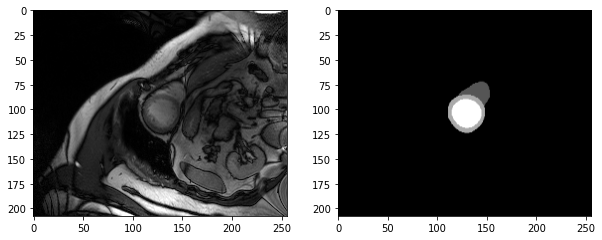

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(V_nifti.get_fdata()[:,:,5,3], cmap='gray')
plt.subplot(122)
plt.imshow(M_nifti.get_fdata()[:,:,5,3], cmap='gray')

Text(0, 0.5, 'Volume (mL)')

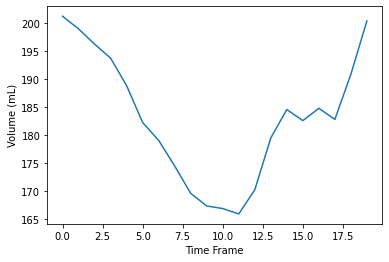

In [19]:
plt.plot((M_nifti.get_fdata()==3).sum(axis=(0,1,2))*np.prod(M_nifti.header.get_zooms()[:3])/1000)
plt.xlabel('Time Frame')
plt.ylabel('Volume (mL)')

#### Motion Estimation

Now that we have the 4D segmentations we can calculate strain: 

In [83]:
df = {'SubjectID':[], 'RadialStain':[], 'CircumferentialStrain':[], 'TimeFrame':[], 'Group':[]}

start = time.time()
for j, id in enumerate(range(1, 101)):
    print('subject %d / %d'%(j+1, 100))
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    group = info.Group.item().strip(' ')
    
    V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
    M_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d_gt.nii.gz'))

    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti_resampled = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)

    center = center_of_mass(M_nifti_resampled.get_fdata()[:,:,:,0]==2)
    V = _roll2center_crop(x=V_nifti_resampled.get_fdata(), center=center)
    M = _roll2center_crop(x=M_nifti_resampled.get_fdata(), center=center)
    
    V = normalize(V, axis=(0,1,2))
    
    V = V.transpose((3,0,1,2))
    M = M.transpose((3,0,1,2))
    
    V_0 = np.repeat(V[:1], len(V)-1, axis=0)[...,None]
    V_t = V[1:][...,None]
    
    y_t = netME([V_0, V_t]).numpy()
    y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

    mask_end_diastole = M[0]

    for time_frame in range(len(y_t)):

        strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[time_frame,:,:,:,:])
        strain.calculate_strain(lv_label=2)

        df['SubjectID']             += [id]
        df['RadialStain']           += [100*strain.Err[strain.mask_rot==2].mean()]   
        df['CircumferentialStrain'] += [100*strain.Ecc[strain.mask_rot==2].mean()]
        df['TimeFrame']             += [time_frame]
        df['Group']                 += [group]
    
    
df = pd.DataFrame(df)

subject 1 / 100
subject 2 / 100
subject 3 / 100
subject 4 / 100
subject 5 / 100
subject 6 / 100
subject 7 / 100
subject 8 / 100
subject 9 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 10 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 11 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 12 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 13 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 14 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 15 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 16 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 17 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 18 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 19 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 20 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 21 / 100
subject 22 / 100
subject 23 / 100
subject 24 / 100
subject 25 / 100
subject 26 / 100
subject 27 / 100
subject 28 / 100
subject 29 / 100
subject 30 / 100
subject 31 / 100
subject 32 / 100
subject 33 / 100
subject 34 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 35 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 36 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 37 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 38 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 39 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 40 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 41 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 42 / 100
subject 43 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 44 / 100
subject 45 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 46 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 47 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 48 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 49 / 100
subject 50 / 100
subject 51 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 52 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 53 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 54 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 55 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 56 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 57 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 58 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 59 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 60 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 61 / 100
subject 62 / 100
subject 63 / 100
subject 64 / 100
subject 65 / 100
subject 66 / 100
subject 67 / 100
subject 68 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 69 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 70 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 71 / 100
subject 72 / 100
subject 73 / 100
subject 74 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 75 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 76 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 77 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 78 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 79 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 80 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 81 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 82 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 83 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 84 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 85 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 86 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 87 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 88 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 89 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 90 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 91 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 92 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 93 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 94 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 95 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 96 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 97 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 98 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 99 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


subject 100 / 100


../data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


#### Comparison 

The figure below shows our published figure. 

In [90]:
from IPython.display import Image
Image(url= "https://www.frontiersin.org/files/Articles/730316/fcvm-08-730316-HTML-r1/image_m/fcvm-08-730316-g007.jpg")

And these are the results based on this repo: 

<AxesSubplot:xlabel='TimeFrame', ylabel='RadialStain'>

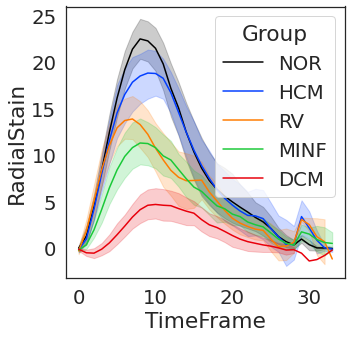

In [104]:
groups = ['NOR','HCM','RV','MINF','DCM']

current_palette = sns.color_palette()
current_palette = [(0,0,0)] + current_palette
sns.set(style='white', font_scale=1.8, palette="bright")

plt.figure(figsize=(5,5))
sns.lineplot(x='TimeFrame', y='RadialStain', hue='Group', data=df, palette=current_palette[:5], hue_order=groups)

### WHY THE DIFFERENCES? 

The images are not identical. In this notebook we are not taking into account the temporal resolution of the datasets. This can be extracted from the DICOMs. In fact, the temporal resolution is required to evaluate strain rate. We will address this in later notebooks. 